<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20220930_Bike_Sharing_Demand_RMSLE_GridSearchCV_Seaborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 자전거 대여 수요 예측
 - 날짜, 계절, 근무일 여부, 날씨, 온도, 풍속 데이터 활용 → 자전거 대여 수량 예측
 - 문제유형 : 회귀
 - 평가지표 : RMSE
 - 사용모델 : 랜덤 포레스트 회귀

In [2]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [3]:
train.shape, test.shape # 피처(특징) 개수에서 차이가 남

((10886, 12), (6493, 9))

In [4]:
# 길이가 다른 리스트 비교 : set() 활용
set(train.columns) - set(test.columns) # 'count'는 종속변수(target)

{'casual', 'count', 'registered'}

 - 모델 훈련시에도 'casual', 'registered' 제외 해야함

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


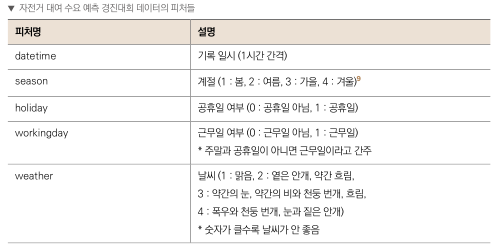

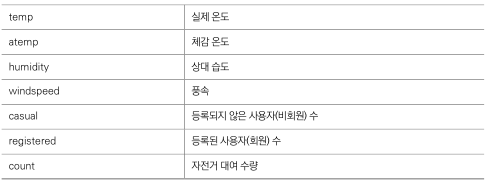

In [7]:
# 각 피처별 고유값이 몇개나 있는지 확인

dict = {}
for col in train.columns:
    if train[col].nunique() < 30:   # 고유값이 너무 많으면 범주형데이터라고 보기 어려움
        dict[col] = train[col].unique()
    else:
        pass
dict

{'season': array([1, 2, 3, 4]),
 'holiday': array([0, 1]),
 'workingday': array([0, 1]),
 'weather': array([1, 2, 3, 4]),
 'windspeed': array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
         8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
         7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
        40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])}

 - train, test데이터는 날짜를 기준으로 train:1-19일, test:20-30일로 나눠놓음

In [8]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


 - 'datetime' 피처는 1시간 간격의 데이터 구분 역할
 - 즉, 인덱스와 다를바가 없으므로 삭제
 - 삭제하기 전에 datetime피처에서 쓸만한 피처를 추출할 예정(시기에 따른 대여변화가 있을 수 있으므로)

In [9]:
# 겉보기엔 날짜/시간 이지만 object 타입(판다스의 문자열)
# object 타입이기때문에 문자열처럼 다룰수 있음
train['datetime'][100] # '2011-01-05 09:00:00'
train['datetime'][100].split() # ['2011-01-05', '09:00:00']
train['datetime'][100].split()[0] # '2011-01-05'
train['datetime'][100].split()[1] # '09:00:00'

'09:00:00'

In [10]:
train['datetime'][100].split()[0] # '2011-01-05'
train['datetime'][100].split()[0].split('-') # ['2011', '01', '05']
train['datetime'][100].split()[0].split('-')[0] # '2011' → 연도
train['datetime'][100].split()[0].split('-')[1] # '01' → 월
train['datetime'][100].split()[0].split('-')[2] # '05' → 일

'05'

In [11]:
train['datetime'][100].split()[1] # '09:00:00'
train['datetime'][100].split()[1].split(':') # ['09', '00', '00']
train['datetime'][100].split()[1].split(':')[0] # '09' → 시
train['datetime'][100].split()[1].split(':')[1] # '00' → 분
train['datetime'][100].split()[1].split(':')[2] # '00' → 초

'00'

In [12]:
# datetime에서 몇가지 파생피처를 생성 : DF/Series.apply()
train['date'] = train['datetime'].apply(lambda x: x.split()[0]) # 날짜 피처 생성

train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0]) # 연도 피처 생성
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1]) # 월 피처 생성
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2]) # 일 피처 생성
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0]) # 시 피처 생성
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1]) # 분 피처 생성
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2]) # 초 피처 생초

In [13]:
# 날짜(object 타입) → 날짜(datetime 타입) → 요일(int타입) → 요일(object 타입)

from datetime import datetime
import calendar

train['date'][100] # 2011-01-05 : str
datetime.strptime(train['date'][100], '%Y-%m-%d') # datetime.datetime(2011, 1, 5, 0, 0) : datetime.datetime
datetime.strptime(train['date'][100], '%Y-%m-%d').weekday() # 2 : int
calendar.day_name[2] # Wednesday : str

'Wednesday'

In [14]:
train['weekday'] = train['date'].apply(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])

In [15]:
dict

{'season': array([1, 2, 3, 4]),
 'holiday': array([0, 1]),
 'workingday': array([0, 1]),
 'weather': array([1, 2, 3, 4]),
 'windspeed': array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
         8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
         7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
        40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])}

 - season과 weather 피처는 숫자로 표현되어 있음
 - 의미파악이 쉽도록 문자열로 변경 : map()

In [16]:
# DF/Series.map({변경전:변경후})
train['season'] = train['season'].map({1:'Spring',
                                        2:'Summer',
                                        3:'Fall',
                                        4:'Winter'}) 
train['weather'] = train['weather'].map({1:'Clear',
                                        2:'Mist, Few Coluds',
                                        3:'Light Snow, Rain, Thunderstorm',
                                        4:'Heavy Rain, Thunderstorm, Snow, Fog'}) 

In [17]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


 - 세분화된 month피처 → 세달씩 묶어서 season피처로
 - 지나치게 세분화된 피처를 더 큰 분류로 묶으면 성능이 좋아지기도 함

  > 데이터를 지엽적으로 판단하기 보다는 큰 흐름을 보는것이 좋음

### 데이터 시각화

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

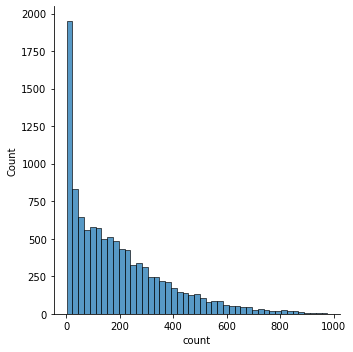

In [19]:
sns.displot(train['count']) # 타깃값인 count피처의 분포도

 - 타깃값인 count가 0근처에 몰려있음

  > 자전거대여횟수가 0인 날이 매우 많음

 - 분포가 편향되어 있어서 좋은 성능을 내기 어렵다 → 정규분포에 가깝게 만들어 주자

  > 로그변환 : 데이터가 왼쪽으로 편향시 주로 사용

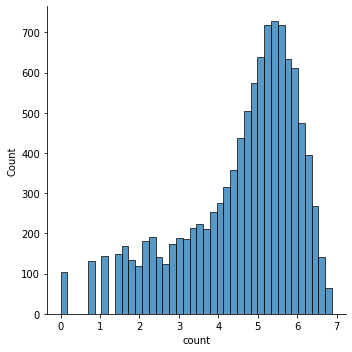

In [20]:
sns.displot(np.log(train['count']))

 - 로그변환 함에 따라 정규분포에 조금더 가까워짐
 - count예측이 아닌, log(count)를 예측하고
  
  > 마지막에 지수변환하여 count로 복원

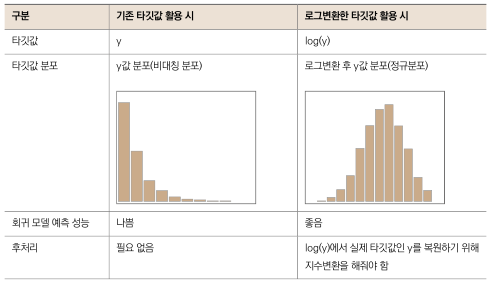

 - 범주형 피처('연도','월','일','시','분','초')에 따라 평균 대여수량이 어떻게 다른지 확인

  > 상관관계(추세확인 가능한지여부)를 통해 피처의 중요도 파악

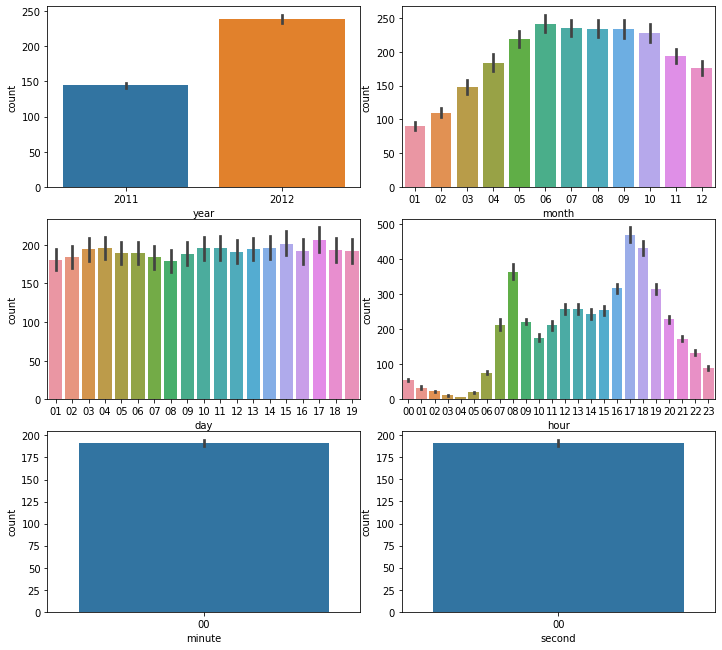

In [21]:
# subplots() 활용
fig, axes = plt.subplots(nrows=3, ncols=2) # 

fig.set_size_inches(10, 9) # 전체 Figure 사이즈
plt.tight_layout() # 서브플롯간의 간격을 확보(이름은 tight지만 의미는 다름)

for idx, x in enumerate(['year','month','day','hour','minute','second']):
    sns.barplot(x=x, y='count', data=train, ax=axes[idx // 2, idx % 2]) # ax 파라미터 : 2차원 배열

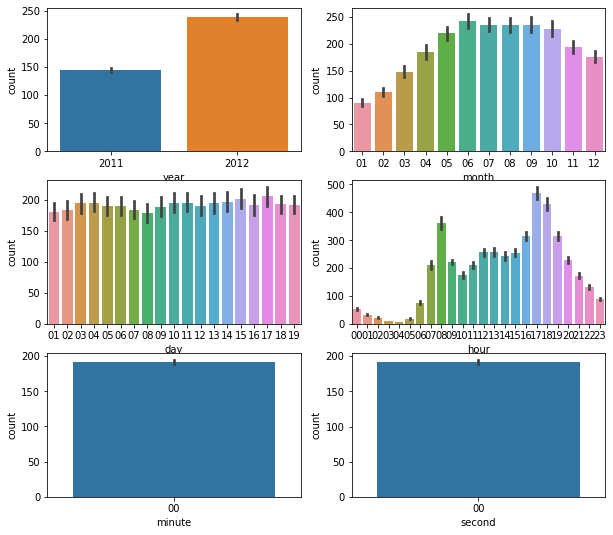

In [22]:
# GridSpec 활용1
# ax = fig.add_subplot(gs) : GridSpec객체를 생성하여 figure에 축으로 밀어넣고 subplots()메서드 처럼 활용
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 9))
gs = GridSpec(nrows=3, ncols=2)

for idx, x in enumerate(['year','month','day','hour','minute','second']):
    ax = fig.add_subplot(gs[idx]) # GridSpec()활용하면 2차원 축을 1차원 처럼 활용가능, 축 객체생성
    sns.barplot(x=x, y='count', data=train, ax=ax) # 축객체에 plot

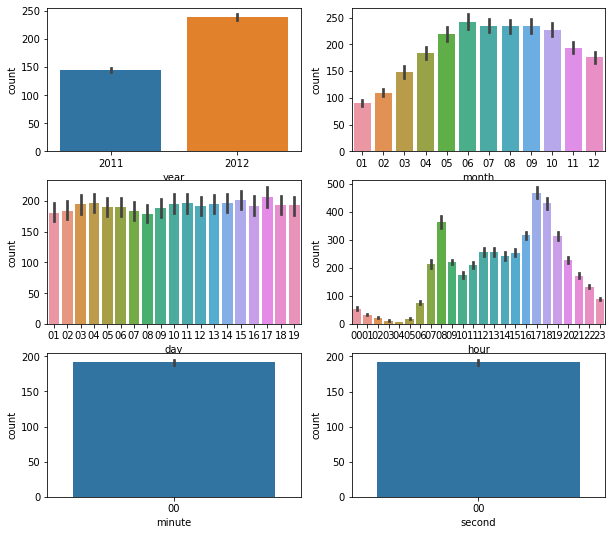

In [23]:
# GridSpec 활용2
# ax = plt.subplot(gs[i]) : subplot()메서드 활용하여 함수형으로 코딩

fig = plt.figure(figsize=(10, 9))
gs = GridSpec(nrows=3, ncols=2)

for idx, x in enumerate(['year','month','day','hour','minute','second']):
    plt.subplot(gs[idx]) # 축을 GridSpec()에 따라 순차적으로 생성(축 객체 생성하지 않음)
    sns.barplot(x=x, y='count', data=train) # 순차적으로 plot(축을 지정하지 않음)

 - GridSpec()활용시 장점
  
  > 축을 별도로 지정하거나, 함수형 프로그래밍 방식으로 다양하게 사용가능

  > 여러개의 서브플롯 사용시에도 그리드스펙 객체를 1차원 형태로 편하게 사용가능

 - 범주형 피처('계절','날씨','공휴일','근무일')에 따라 평균 대여수량이 어떻게 다른지 확인

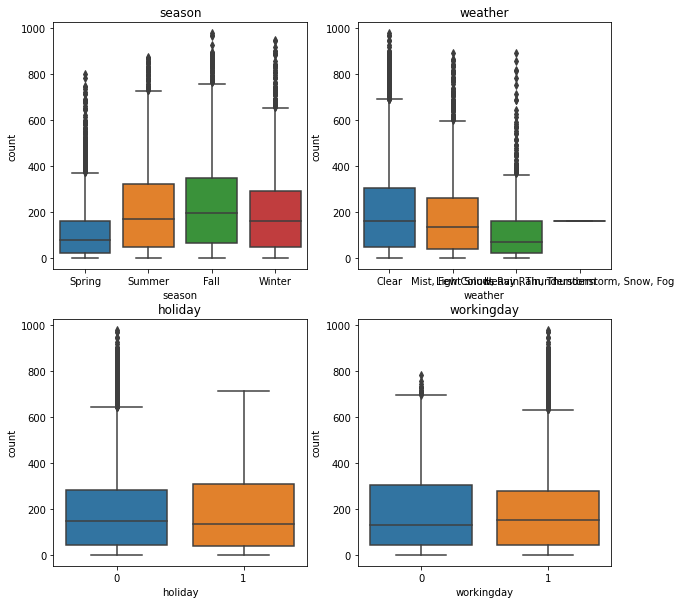

In [24]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=2)

for idx, x in enumerate(['season','weather','holiday','workingday']):
    # 방법1 : 축객체를 생성 → 축에다가 plot
    ax = fig.add_subplot(gs[idx])
    sns.boxplot(x=x, y='count', data=train, ax=ax)
    ax.set_title(f'{x}')
    # 방법2 : 축을 그림 → plot
    # plt.subplot(gs[idx])
    # sns.boxplot(x=x, y='count', data=train)

 - holiday : 0 : 공휴일 아님, 1 : 공휴일
 - workingday : 0 : 공휴일 또는 주말, 1 : 근무일
 - 두가지 의미는 거의 비슷

 - 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여수량

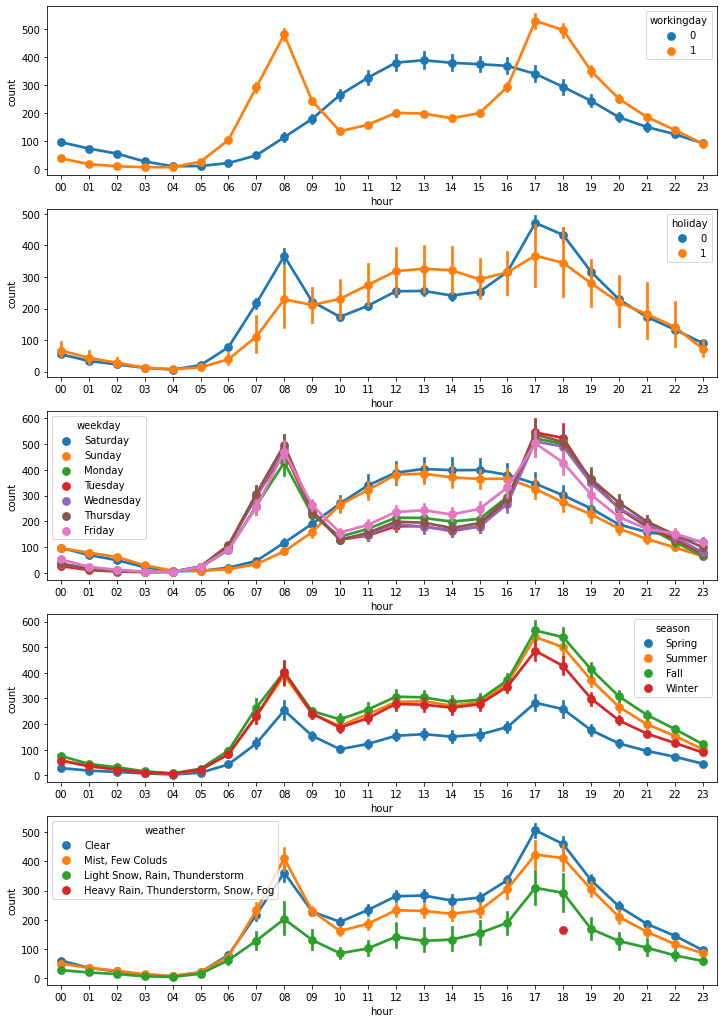

In [25]:
fig = plt.figure(figsize=(12, 18))
gs = GridSpec(nrows=5, ncols=1)

for idx, x in enumerate(['workingday','holiday','weekday','season','weather']):
    ax = fig.add_subplot(gs[idx])
    sns.pointplot(x='hour', y='count', data=train, hue=x, ax=ax)

 - 수치형 데이터(온도, 체감, 온도, 풍속, 습도)별 대여 수량을 '회귀선을 포함한 산점도 그래프'로 표현
  
  > 수치형 데이터간 상관관계를 파악하는데 사용

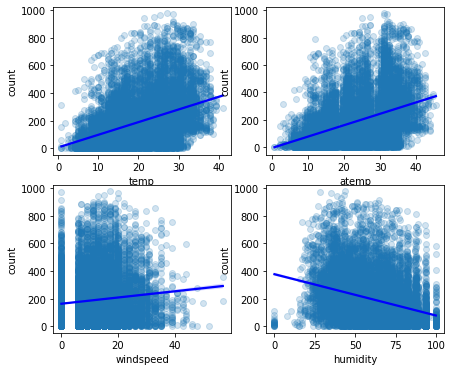

In [26]:
fig = plt.figure(figsize=(7, 6))
gs = GridSpec(nrows=2, ncols=2)

for idx, x in enumerate(['temp','atemp','windspeed','humidity']):
    ax = fig.add_subplot(gs[idx])
    # regplot : regression plot의 줄임말
    sns.regplot(x=x, y='count', data=train, ax=ax,
                  scatter_kws={'alpha':0.2},    # 산점도 그래프에 찍히는 점의 투명도
                  line_kws={'color':'blue'})    # 회귀선의 색상

 - windspeed - count의 상관관계 plot에서
 - 0에서의 데이터 값이 많은것은 실제로 풍속이 0이 아니라
 - 관측치가 없거나 오류로 인해 0으로 기록됬을 가능성이 높음

  > windspeed - count간의 상관관계 파악이 어려우므로 피처 삭제

 - 수치형 피처간의 상관관계 파악을 위해 히트맵 사용 : corr(), heatmap()

In [27]:
# DF.corr()
train[['temp','atemp','humidity','windspeed','count']].corr() # DataFrame내의 피처 간 상관계수를 계산해 반환

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


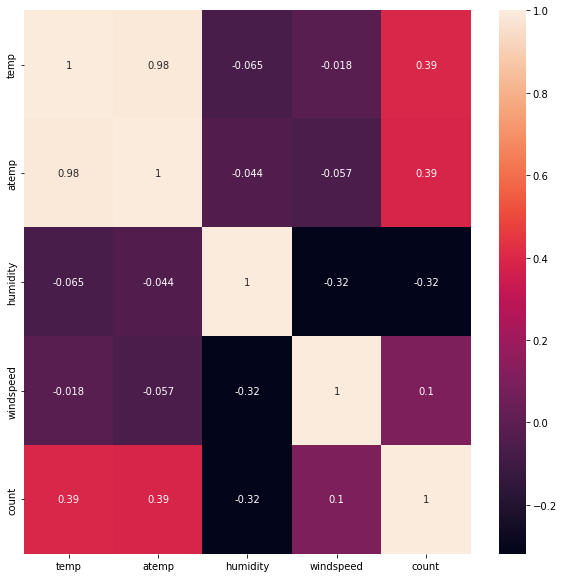

In [28]:
# 피처 간 상관관계 매트릭스
corrMat = train[['temp','atemp','humidity','windspeed','count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrMat, annot=True) # annot : 상관관계 숫자 표시

 - (-)음수이면, 음의 상관관계

## 베이스라인 모델

In [29]:
# 앞서 데이터 분석 및 시각화를 위해 몇가지 피처를 변환했으므로, 다시 원래의 데이터셋으로 불러옴
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

### 피처 엔지니어링
 - 훈련 데이터와 테스트 데이터에 공통으로 반영
 - 피처 엔지니어링 전에 합쳤다가 후에 다시 나눠줌

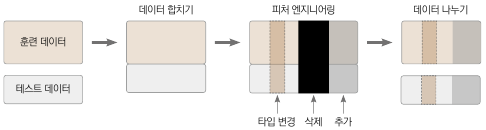

#### 이상치 제거
 - weather : 4인날 자전거를 대여한 이상치 한건

In [30]:
# 훈련데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

#### 데이터 합치기
 - 판다스의 pd.concat([df1, df2]) 함수

In [31]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


#### 파생피처 추가
 - train에만 추가했던 파생피처를 train, test를 합친 상태에서 다시 적용

In [32]:
from datetime import datetime

all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0]) # 날짜 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0]) # 연도 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1]) # 월 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0]) # 시 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday()) # 요일 피처 생일(문자아닌 정수로로

#### 필요없는 피처 제거
 - 테스트 데이터에 없는 피처 : casual, registered
 - 인덱스 역할만 하는 피처 : datetime
 - 다른 피처와(year, month, day) 중복되는 의미를 갖는 피처 : date
 - 대분류(season)를 갖는 세분화된 피처 : month
 - 결측값이 많아 상관관계 파악이 안되는 피처 : windspeed

In [33]:
drop_features = ['casual','registered','datetime','date','month','windspeed']
all_data = all_data.drop(drop_features, axis=1) # DF.drop([col1,col2], axis=1) 

#### 데이터 나누기
 - 피처엔지니어링 적용 후 다시 train과 test데이터를 나눔
 - 타깃값인 count피처의 값이 있냐 없냐기준으로 나눔
 - pd.isnull(all_data['count'])

In [34]:
X_train = all_data[~pd.isnull(all_data['count'])] # count피처의 값이 없지 않으면 훈련 데이터
X_test = all_data[pd.isnull(all_data['count'])] # count피처의 값이 없으면 테스트 데이터

In [35]:
# 타깃값인 count 피처 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값 

In [36]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


### 평가지표 계산 함수 작성
 - 훈련이 제대로 이루어 졌는지 확인하기위한 수단, 즉 평가지표 필요
 - 경진대회의 평가지표인 RMSE를 계산하는 함수 제작

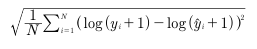

 - log(y+1)에서 +1을 하는 이유는 y가 0으로 가서 무한대 음수가 되는것을 피하고자 함

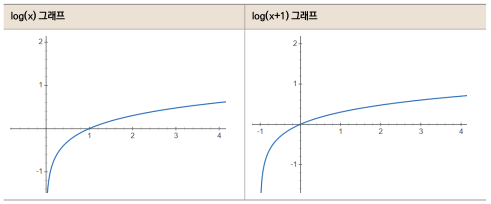

In [37]:
import numpy as np

# 이미 데이터셋의 target값인 count는 "회귀모델 학습을 위해 로그변환" 되어 있으므로 지수변환하여 계산
def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp: # True라면
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    # 로그변환 → 결측값을 0으로 변환
    log_true = np.log(y_true+1) # np.log() : 밑이 e인 로그
    log_true = np.nan_to_num(log_true) # np.nan_to_num(배열) : 배열의 결측치(NaN)를 0으로, DF.fillna(0) : 데이터프레임의 결측치를 0으로
    log_pred = np.log(y_pred+1)
    log_pred = np.nan_to_num(log_pred)

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return output

### 모델 훈련
 - 가장간단한 선형 회귀 모델 : LinearRegression

In [38]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [39]:
log_y = np.log(y) # 타깃값 로그변환 : 회귀모델에서 타깃값의 분포는 정규분포에 가까울수록 좋기때문
linear_reg_model.fit(X_train, log_y) # 모델 훈련 : 타깃값을 로그변환하여 훈련

LinearRegression()

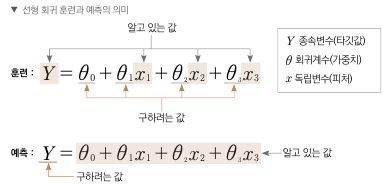

### 모델 성능 검증
 - 검증데이터를 따로 나누지 않았기 때문에
 - 훈련데이터셋으로 훈련 → 훈련데이터로 예측
 - → 훈련데이터 예측값과 훈련데이터 타깃값으로 검증 : **사실 이렇게 하면 안됨**

  > 훈련에 사용되지 않은 데이터를 입력으로 넣고, 예측해야함

  > 훈련데이터에서 다시 훈련데이터+검증데이터로 나눴어야함

In [40]:
preds = linear_reg_model.predict(X_train) # 모델 예측 : 예측하여 나온 값도 로그변환이 적용된 것이나 마찬가지

In [41]:
preds

array([2.19541075, 2.27905813, 2.38251905, ..., 5.6734502 , 5.82792117,
       5.82067058])

In [42]:
print(f'선형 회귀의 RMSLE 값 : {rmsle(log_y, preds):.4f}')

선형 회귀의 RMSLE 값 : 1.0205


In [43]:
# 테스트 데이터로 예측
linearreg_preds = linear_reg_model.predict(X_test)

submission['count'] = np.exp(linearreg_preds) # 최종적인 대여수량 count를 지수변환 해주어야함

## 성능 개선1 : 릿지 회귀 모델
 - 사이킷런이 제공하는 모델 3가지 비교해보자
 - 릿지, 라쏘, 랜덤 포레스트
 - 릿지 회귀모델은 L2 규제 적용한 선형 회귀 모델(성능은 좋지 않음)
 - 규제 : 모델이 훈련 데이터에 과대적합 되지 않도록 하는것

### 모델 훈련단계에서 하이퍼파라미터 최적화
 - 하이퍼파라미터 최적화 기법 중 **그리드 서치** 사용
 - 릿지 회귀모델에 사용되는 하이퍼파라미터 : alpha
 - 그리드서치는 **주어진 하이퍼파라미터를 모두사용**하며,
 - 교차 검증용 평가수단에 따라 **교차검증까지 수행함**

#### 모델 생성 → 그리드서치 객체 생성 → 그리드서치 수행

In [44]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge() # 릿지 모델 생성

##### 그리드서치 객체 생성 #####
# 1. 하이퍼파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1,1,2,5,10,100,200]}

# 2. 교차 검증용 평가 함수(직접만든 함수 적용) 생성
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 2-1. 별도로 만든 평가지표를 교차 검증용 평가함수로 사용하기 : metrics.make_scorer(직접만든 함수)
# 2-2. 사이킷런 제공 평가지표를 교차 검증용 평가함수로 사용하기 : 'accuracy','f1','roc_auc' 등
## scoring = 'accuracy' 문자열을 적용하면, 내부적으로 metrics.accuracy_score() 객체가 생성됨

# 3. 그리스서치(+릿지모델을 적용한) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,    # (분류/회귀) 모델전달
                                      param_grid=ridge_params,  # 파라미터 전달(딕셔너리 형태)
                                      scoring=rmsle_scorer,     # 교차검증용 평가함수 전달(직접만들어도 됨)
                                      cv=5) #                   # 교차검증 분할 개수(기본값은 5)

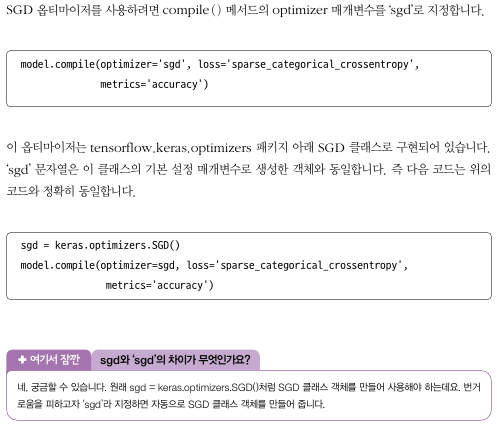

In [45]:
##### 그리드서치 수행 #####
# 그리드서치를 통해 교차 검증용 평가함수를 기준으로 교차검증하여 최적의 하이퍼파라미터를 찾고
# 최적의 하이퍼파라미터를 적용한 모델을 반환 : .best_estimaor_
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 릿지모델을 적용한 그리드서치 객체에 훈련

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 5, 10, 100, 200],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

 - 이때 가장 좋은 성능을 보인 값을 best_params_ 속성에 저장
 - 이 최적의 파라미터로 훈련한 "모델"을 best_estimator_ 속성에 저장

  > 즉, 모델.best_estimator_.predict()로 예측

In [46]:
print('최적의 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적의 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


### 성능 검증
 - 최적의 파라미터로 훈련한 모델이 저장된 best_estimator_로 예측 수행

In [47]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) # 예측

In [48]:
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds):.4f}') # 평가

릿지 회귀 RMSLE 값 : 1.0205


## 성능 개선 2 : 라쏘 회귀 모델
 - 릿지, 라쏘 회귀 모델 모두 성능이 좋은편 아님
 - 직접만드는 모델은 최소한 이것보다 성능이 나와야함

In [49]:
from sklearn.linear_model import Lasso


lasso_model = Lasso() # 라쏘 모델 생성

##### 그리드 서치 객체 생성 #####
# 1. 하이퍼파라미터 값 목록
lasso_params = {'max_iter':[3000], 'alpha':1/np.array([0.1, 2, 5, 10, 100, 500, 1000])}
# 2. 교차 검증용 평가 함수(직접만든 함수 적용) 생성
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 3. 그리스서치(+라쏘모델을 적용한) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드 서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

# 최적의 파라미터 확인
print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.002, 'max_iter': 3000}


### 성능 검증

In [50]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train) # 예측

In [51]:
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds):.4f}') # 평가

라쏘 회귀 RMSLE 값 : 1.0205


## 성능 개선 3 : 랜던 포레스트 회귀 모델
 - 훈련 데이터를 랜덤하게 샘플링한 모델 n개를 각각 훈련하여 결과를 평균

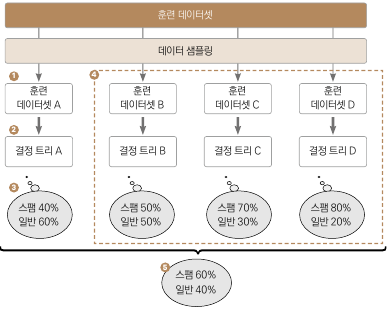

In [52]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor() # 모델 생성

##### 그리드 서치 객체 생성 #####  
# 1. 하이퍼파라미터 값 목록
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]} # 결정 트리의 개수

# 2. 교차 검증용 평가 함수(직접만든 함수 적용) 생성
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 3. 그리스서치(+라쏘모델을 적용한) 객체 생성
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적의 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적의 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


### 모델 성능 검증

In [53]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train) # 예측

In [54]:
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


 - RMSLE 값은 작을 수록 모델 성능이 좋음


#### 예측

Text(0.5, 1.0, 'Predicted Test Data Distribution')

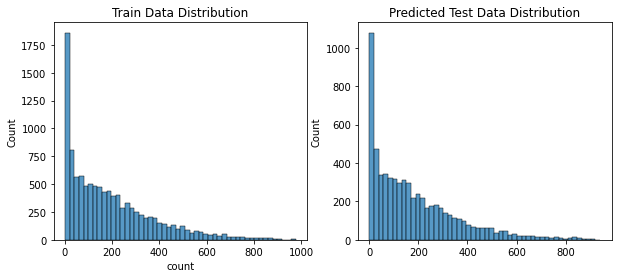

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

fig, axes = plt.subplots(ncols=2) # histplot을 사용하여 ax 마다 다르게 plot 하기위해 subplots() 적용
fig.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0]) # train데이터셋의 target인 count 값의 분포
axes[0].set_title('Train Data Distribution')

sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1]) # log(y)로 훈련한 모델로 예측한 값을 다시 지수변환
axes[1].set_title('Predicted Test Data Distribution')

#### 핵심요약
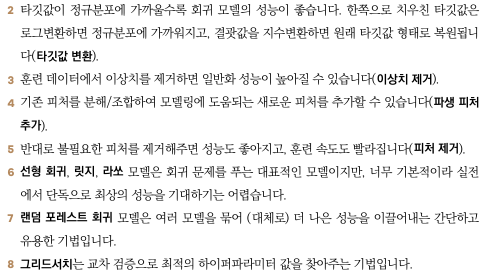

#### 참고 : seaborn 사용법
[링크 텍스트](https://hwi-doc.tistory.com/entry/seaborn-%EC%99%84%EB%B2%BD-%EC%A0%95%EB%A6%AC)

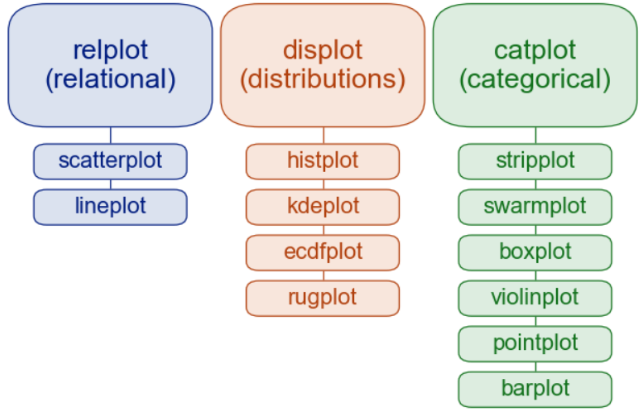

 - 'figure-level' 또는 'axes-level' 함수로 나뉘어져 있음

 - figure-level 함수 : relplot, displot, catplot

  >  matplotlib 와 별개로 seaborn 의 figure를 만들어 그곳에 plotting

  > kind 파라미터를 통해 그래프 타입 지정

  > col 파라미터를 통해 groupby

```
# displot을 통해 figure을 확보하고 kind를 통해 함수 선택, kind가 없으면 default 인 histplot 선택
sns.displot(data=penguins, x="flipper_length_mm", hue="species", multiple="stack", kind="kde") 
```
```
# col을 활용한 groupby
g = sns.displot(data=penguins, x="flipper_length_mm", hue="species", col="species", kind = 'kde')
g.set_axis_labels('x','y') # x,y 축 이름을 변경할 수 있음
```


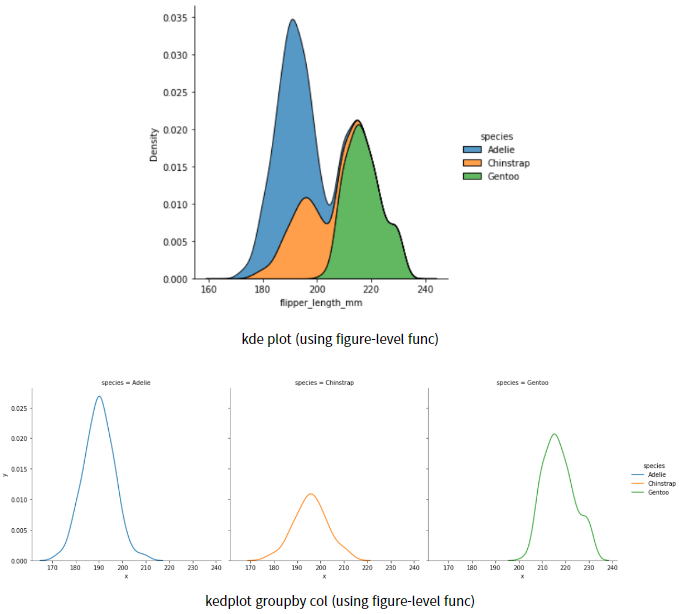

 -  'axes-level' 함수 : scatterplot, histplot, boxplot 등

  > ax 파라미터를 통해 plotting 할 곳을 지정

```
f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
 
sns.scatterplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species", ax=axs[0])
sns.histplot(data=penguins, x="species", hue="species", shrink=.8, alpha=.8, legend=False, ax=axs[1])
```



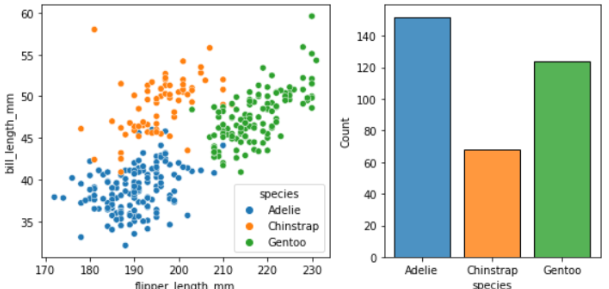